# Temporal difference methods

In Monte Carlo methods, we update our estimate of the value function as 

$$V(\mathbf{s}_t) \leftarrow V(\mathbf{s}_t) + \alpha \cdot [g_t - V(\mathbf{s}_{t+1})]$$

Where $g_t$ denote the cumulative reward starting from state $\mathbf{s}_t$. The action value function is updated in a similar manner

$$Q(\mathbf{s}_t, \mathbf{a}_t) \leftarrow Q(\mathbf{s}_t, \mathbf{a}_t) + \alpha \cdot [g_t - Q(\mathbf{s}_{t+1}, \mathbf{a}_{t+1})]$$

One drawback of this approach is that the parameter update occurs only after the trajectory ends. This can be less desirable if generating a trajectory is computationally expensive. The Temporal Difference (TD) method differs from the Monte Carlo approach in that it performs updates during the generation of the trajectory. This allows for meaningful progress while interacting with the environment. Formally, the TD method updates the value function as follows:

$$V(\mathbf{s}_t) \leftarrow V(\mathbf{s}_t) + \alpha \cdot [r_t + \gamma V(\mathbf{s}_{t+1}) - V(\mathbf{s}_{t})]$$

In other words, instead of using the discounted future reward $g_t$, which is only available after the trajectory has ended, temporal difference uses the bootstrap estimate $r_t + \gamma V(\mathbf{s}_{t+1})$, which can be computed immediately at each timestep. The psuedocode of temporal difference method is provided below. 

```{prf:algorithm} Temporal difference policy evaluation
:label: my-algorithm

**Inputs** Policy $\pi$ to be evaluated

**Output** Value function $V_{\pi}(s)$ for each state $s\in \mathcal{S}$

1. Initialize $V(s)$ arbitrary for all $s$ expect for terminal states
2. For each episode
	1. Initialize state $\mathbf{s}_0$
	2. While not terminate
		1. Sample $\mathbf{a}_t \sim \pi(\cdot|\mathbf{s}_t)$
		2. Take action $\mathbf{a}_t$, observe $r_t, \mathbf{s}_{t+1}$
        3. Update $V(\mathbf{s}_t) \leftarrow V(\mathbf{s}_t) + \alpha[r_t +\gamma V(\mathbf{s}_{t+1})-V(\mathbf{s}_t)]$
```

Algorithm 6.1 can be extended to estimate the state action value function, which then can be used for control. We discuss this in the next section. 

## Cliff walking

We implement TD algorithm to estimate the value function of policies from the OpenAI gym Cliff walking enviroment. In the cliff walking enviroment, there are $48$ states and $4$ actions. When the agent arrive at the right-bottom corner, the agent recieves a reward of $+10$. When the agent arrive at the cliffs, the agent recieves a penalty of $-100$. The living penalty is set to $-1$ for all states. 

```{image} cliff_walking.gif
:alt: fishy
:class: bg-primary mb-1
:width: 500px
:align: center
```

<p style="text-align: center; font-size: 14px;"> 
    <strong> Figure 1 </strong>: The cliff walking enviroment
</p>

## Temporal Difference Policy Evaluation Implementation

We now estimate the value function of a random policy in the cliff walking environment. 

In [1]:
import gym
import numpy as np
import time
import imageio
import matplotlib.pyplot as plt
from td import *

In [13]:
def estimate_value_function(env: any, policy: Policy, n_episodes: int, gamma: float, alpha: float):
    """
    Estimates the value function following algorithm 6.1
    """
    states = policy.states
    values = {state: 0 for state in states}
    for episode in range(n_episodes):
        state = env.reset()[0]
        done = False
        while not done:
            action = policy.get_action(state)
            new_state, reward, done, info = env.step(action)[:4]
            values[state] += alpha * (reward + gamma * values[new_state] - values[state])
            state = new_state
            done = reward == -100
            if state == 47:
                reward, done = 10, True
    return values

In [14]:
class RandomPolicy(Policy):
    def get_action(self, state):
        return np.random.choice(self.actions)

In [18]:
env = gym.make('CliffWalking-v0')
states = list(range(env.observation_space.n))
actions = list(range(env.action_space.n))
policy = RandomPolicy(states, actions)
values = estimate_value_function(env, policy, 1000, 0.2, 0.1)

After running for around $1000$ episodes, the value function seems to have converged. The estimated value is shown in the figure below, where the blacked boxes represent the cliff. Note that states near the cliff have much worse value compared to states far away from the cliff, which makes sense since there is a higher chance of falling into the cliff. 

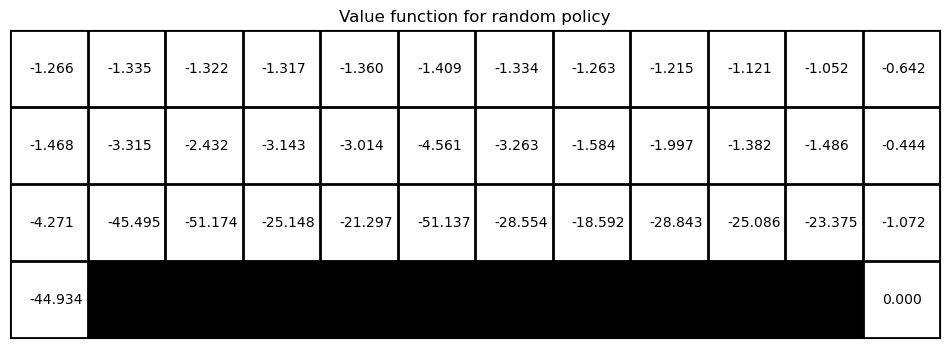

In [21]:
display_values(values)